In [1]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xtrack as xt
import xobjects as xo
import scipy
import xpart as xp 

# Ring design

<Axes: title={'center': 'Extraction bump'}, xlabel='s'>

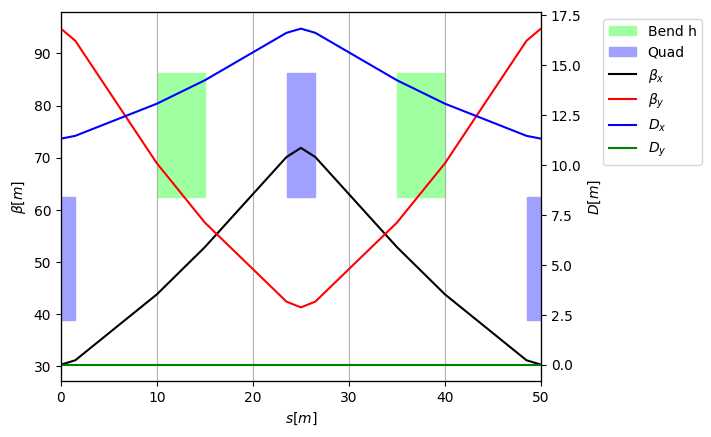

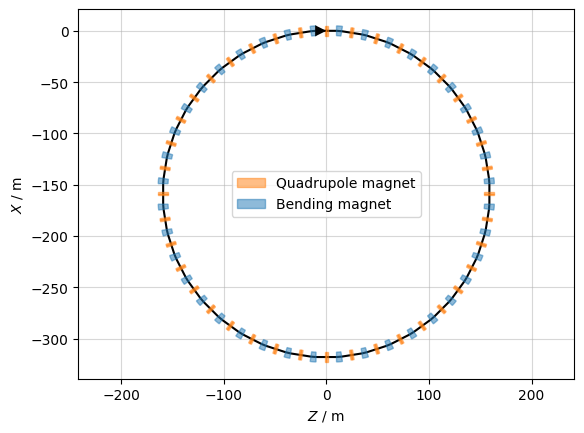

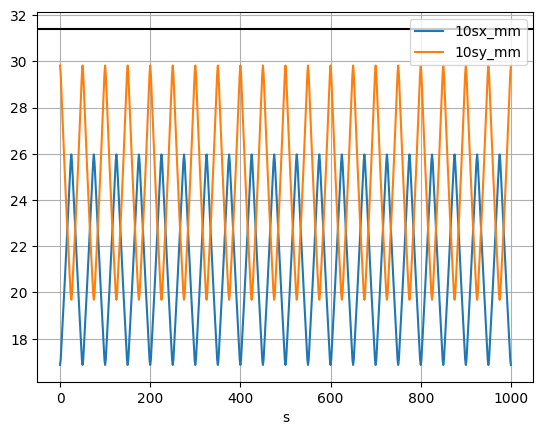

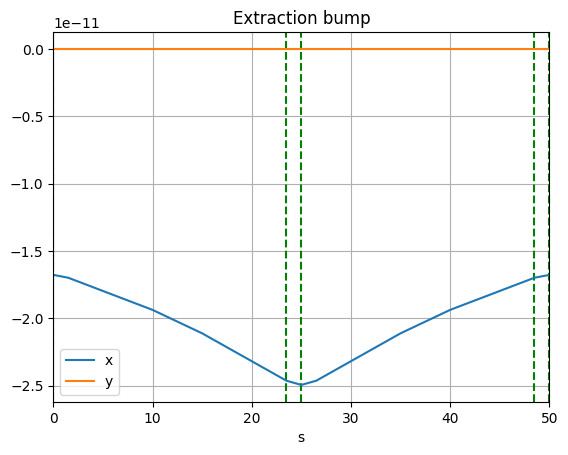

In [24]:
import xtrack as xt


lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
pc_GeV = 20.0
pc = pc_GeV*1e9

Brho = 3.3356*pc_GeV

lFODO = lcirc/number_of_FODO
theta_max = max_dipole_field * lbend / Brho
min_number_of_dipoles = round((2.0*np.pi)/theta_max)
number_of_dipoles_per_FODO = 2
number_of_dipoles = number_of_FODO * number_of_dipoles_per_FODO


target_bmax = 300.0

f_0 = -30

env = xt.Environment()
env['lquad'] = lquad / 2
env['f0'] = f_0
env['k1'] = '1 / f0 / lquad'
env['lsection'] = lFODO
env['lbend'] = lbend
env['k0'] =  2 * np.pi / number_of_dipoles / lbend 
env['lsext'] = 0.5
env['k2f'] = 0
env['k2d'] = 0

bend = env.new('mb', xt.Bend, length='lbend', k0='k0', h='k0', k1=0)
sextf = env.new('sextf', xt.Sextupole, length='lsext', k2='k2f')
sextd = env.new('sextd', xt.Sextupole, length='lsext', k2='k2d')


section = env.new_line(name='section', components=[
    env.new('q1', xt.Quadrupole, length='lquad', k1='k1/2', at='lquad/2'),
    env.place(bend, at='lsection / 4'),
    env.new('q21', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 - lquad/2'),
    env.new('q22', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 + lquad/2'),
    env.place(bend, at='lsection * 3 / 4'),
    env.new('q3', xt.Quadrupole, length='lquad', k1='k1/2', at='lsection - lquad/2'),
    env.new('end', xt.Marker, at='lsection') 
])


env['bump_height'] = 2e-3
env['bump_gap'] = 0.5
env['lbumper'] = 3
env['ramp_length'] = 'lquad/2 + lbend/2 + lsection/4 - bump_gap/2 - lbumper/2 - lquad - lbend - lbumper/2'
env['k0_extr'] = 'bump_height / ramp_length / lbumper'
hbumper1 = env.new('hkick1', xt.Bend, k0='-k0_extr', h=0, length='lbumper')
hbumper2 = env.new('hkick2', xt.Bend, k0='k0_extr', h=0, length='lbumper')
hbumper3 = env.new('hkick3', xt.Bend, k0='k0_extr', h=0, length='lbumper')
hbumper4 = env.new('hkick4', xt.Bend, k0='-k0_extr', h=0, length='lbumper')
extr_section = env.new_line(name='section', components=[
    env.new('q1', xt.Quadrupole, length='lquad', k1='k1/2', at='lquad/2'),
    env.place(bend, at='lsection/4'),
    # env.place(hbumper1, at='lquad + lbend + lbumper/2'),
    # env.place(hbumper2, at='(lquad + lbend + lsection/2) / 2 - bump_gap/2 - lbumper/2'),
    # env.place(hbumper3, at='(lquad + lbend + lsection/2) / 2 + bump_gap/2 + lbumper/2'),
    # env.place(hbumper4, at='lsection/2 - lbumper/2'),
    env.new('q21', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 - lquad/2'),
    env.new('q22', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 + lquad/2'),
    env.place(bend, at='lsection * 3 / 4'),
    env.new('q3', xt.Quadrupole, length='lquad', k1='k1/2', at='lsection - lquad/2'),
    env.new('end', xt.Marker, at='lsection') 
    ])

ring = env.new_line(components = [env.new('_start_point', xt.Marker)] + [extr_section] + (number_of_FODO-1)*[section])

ring.particle_ref = xt.Particles(p0c=pc, mass0=xt.PROTON_MASS_EV) 
context = xo.ContextCpu()
ring.build_tracker(_context=context)

tw = ring.twiss(method='4d')
tw.plot()
plt.xlim(0, env['lsection'])
ring.survey().plot()
# plt.ylim(-20, 10)
# plt.xlim(-env['lsection'], env['lsection'])

gamma = pc / xt.PROTON_MASS_EV
sigma_max = lambda emitt_norm, beta: np.sqrt(emitt_norm*beta / gamma)
tw['10sy_mm'] = sigma_max(emitt_norm=2e-6, beta=tw['bety']) * 1e3 * 10
tw['10sx_mm'] = sigma_max(emitt_norm=2e-6, beta=tw['betx']) * 1e3 * 10
tw.to_pandas().plot(x='s', y=['10sx_mm', '10sy_mm'])
plt.axhline(31.4, color='black')
plt.grid(True)


env['bump_height'] = 2e-3 
tw = ring.twiss(method='4d').to_pandas()
tw.index = tw['name']

fig, ax = plt.subplots()
ax.set_title('Extraction bump')
for idx, row in tw.filter(like='hkick', axis=0).iterrows():
    ax.axvline(row['s'], color='red', linestyle='--')
for idx, row in tw.filter(like='q', axis=0).iterrows():
    ax.axvline(row['s'], color='green', linestyle='--')
tw.plot(x='s', y='x', grid=True, xlim=(0, env['lsection']), ax=ax)
tw.plot(x='s', y='y', grid=True, xlim=(0, env['lsection']), ax=ax)

betx    30.312236
bety    94.747633
alfx          0.0
alfy          0.0
Name: endss1, dtype: object

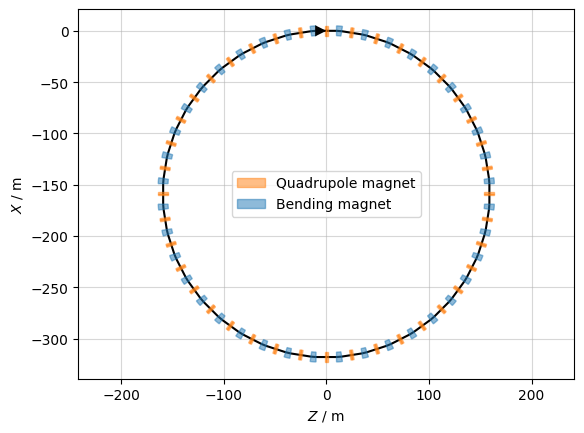

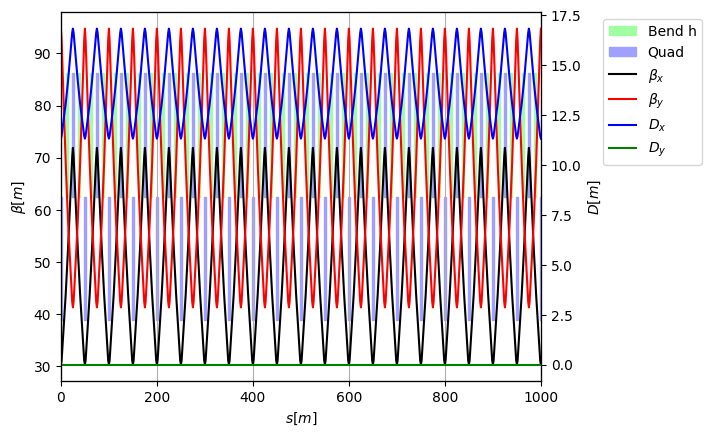

In [3]:
env['lss'] = 0
env['f_ss'] = 'lss / 2 '
env['k_ss'] = '0 * 1 / f_ss / lquad'

straight_section1 = env.new_line(name='ss1', components=[
    env.new('startss1', xt.Marker, at='0'),
    # env.new('qs1.1', xt.Quadrupole, length='lquad', k1='k_ss', at='lquad/2'),
    # env.new('qs1.2', xt.Quadrupole, length='lquad', k1='-k_ss', at='lquad + lquad/2'),
    # env.new('qs1.3', xt.Quadrupole, length='lquad', k1='k_ss', at='2*lquad + lquad/2'),

    # env.place(hbumper1, at='3*lquad + lbumper/2'),
    # env.place(hbumper2, at='lss/2 - bump_gap/2 - lbumper/2'),
    env.new('extrpt', xt.Marker, at='lss/2'),
    # env.place(hbumper3, at='lss/2 + bump_gap/2 + lbumper/2'),
    # env.place(hbumper4, at='lss - 3*lquad - lbumper/2'),

    # env.new('qs1.4', xt.Quadrupole, length='lquad', k1='-k_ss', at='lss - lquad*2 - lquad/2'),
    # env.new('qs1.5', xt.Quadrupole, length='lquad', k1='k_ss', at='lss - lquad - lquad/2'),
    # env.new('qs1.6', xt.Quadrupole, length='lquad', k1='-k_ss', at='lss - lquad/2'),
    
    env.new('endss1', xt.Marker, at='lss') 
    ])

straight_section2 = env.new_line(name='ss2', components=[
    env.new('startss2', xt.Marker, at='0'),
    # env.new('qs2.1', xt.Quadrupole, length='lquad', k1='k_ss', at='lquad/2'),
    # env.new('qs2.2', xt.Quadrupole, length='lquad', k1='-k_ss', at='lquad + lquad/2'),
    # env.new('qs2.3', xt.Quadrupole, length='lquad', k1='k_ss', at='2*lquad + lquad/2'),

    # env.new('qs2.4', xt.Quadrupole, length='lquad', k1='-k_ss', at='lss - lquad*2 - lquad/2'),
    # env.new('qs2.5', xt.Quadrupole, length='lquad', k1='k_ss', at='lss - lquad - lquad/2'),
    # env.new('qs2.6', xt.Quadrupole, length='lquad', k1='-k_ss', at='lss - lquad/2'),
    env.new('endss2', xt.Marker, at='lss') 
    ])

components = [env.new('_start_point', xt.Marker)] + [straight_section1] + (number_of_FODO // 2)*[section] + [straight_section2] + (number_of_FODO // 2)*[section]

ring = env.new_line(components = components)

ring.particle_ref = xt.Particles(p0c=pc, mass0=xt.PROTON_MASS_EV) 
context = xo.ContextCpu()
ring.build_tracker(_context=context)

ring.survey().plot()
tw = ring.twiss(method='4d')
tw.plot()

tw = tw.to_pandas()
tw.index = tw['name']

#plt.ylim(-20, 10)
#plt.xlim(-env['lsection'], env['lsection'])

fodo_init_cond = tw.loc['endss1'][['betx', 'bety', 'alfx', 'alfy']]
fodo_init_cond

In [4]:
lFODO

50.0

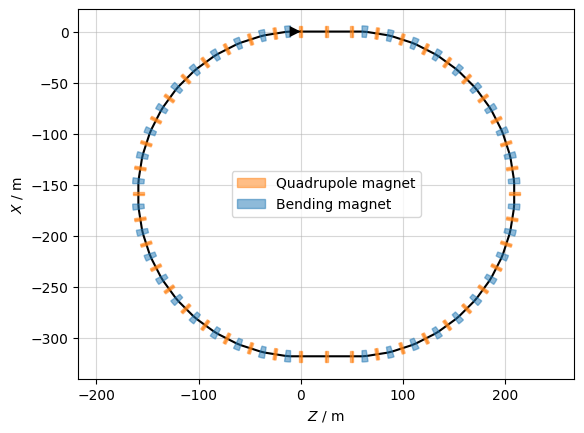

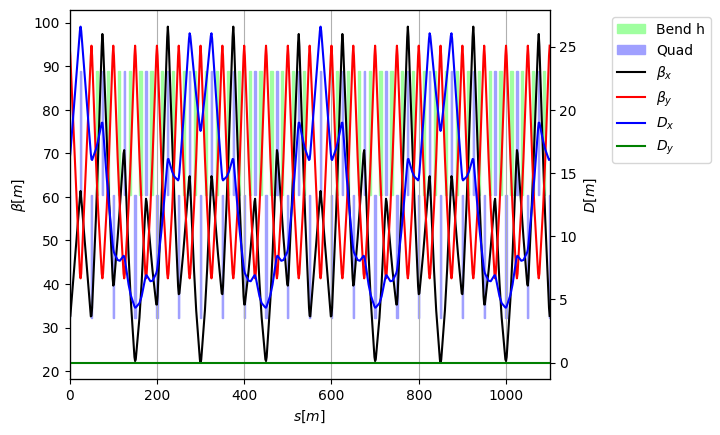

In [28]:
env['triplet_gap'] = 'lsection/2'
env['lss'] = 'lsection'
env['f_ss'] = 'lss / 2 '
env['k1_ss'] = '0 * 1 / f_ss / lquad / 2'
env['k1_ss.1'] = 'k1_ss'
env['k1_ss.2'] = 'k1_ss'
env['k1_ss.3'] = 'k1_ss'
env['k1_ss.4'] = 0

straight_section1 = env.new_line(name='ss1', components=[
    env.new('qs1', xt.Quadrupole, length='lquad', k1='k1/2', at='lquad/2'),
    env.new('qs21', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 - lquad/2'),
    env.new('qs22', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 + lquad/2'),
    env.new('qs3', xt.Quadrupole, length='lquad', k1='k1/2', at='lsection - lquad/2'),
    env.new('end', xt.Marker, at='lsection') 
])

straight_section2 = env.new_line(name='ss2', components=[
    env.new('qs1', xt.Quadrupole, length='lquad', k1='k1/2', at='lquad/2'),
    env.new('qs21', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 - lquad/2'),
    env.new('qs22', xt.Quadrupole, length='lquad', k1='-k1/2', at='lsection/2 + lquad/2'),
    env.new('qs3', xt.Quadrupole, length='lquad', k1='k1/2', at='lsection - lquad/2'),
    env.new('end', xt.Marker, at='lsection') 
])



# straight_section1 = env.new_line(name='ss1', components=[
#     env.new('startss1', xt.Marker, at='0'),
#     env.new('qs1.01', xt.Quadrupole, length='lquad', k1='k1/2', at='lquad/2'),
#     # env.new('qs1.1', xt.Quadrupole, length='lquad', k1='k1_ss.1', at='lquad/2 + triplet_gap'),
#     # env.new('qs1.2', xt.Quadrupole, length='lquad', k1='-k1_ss.2', at='lquad + lquad/2 + triplet_gap'),
#     # env.new('qs1.3', xt.Quadrupole, length='lquad', k1='k1_ss.3', at='2*lquad + lquad/2 + triplet_gap'),
#     #env.new('qs2.4', xt.Quadrupole, length='lquad', k1='-k1_ss.4', at='3*lquad + lquad/2'),

#     # env.place(hbumper1, at='3*lquad + lbumper/2'),
#     # env.place(hbumper2, at='lss/2 - bump_gap/2 - lbumper/2'),
#     env.new('qs1.02', xt.Quadrupole, length='lquad', k1='-k1/2', at='lss/2 - lquad/2'),
#     env.new('extrpt', xt.Marker, at='lss/2'),
#     env.new('qs1.03', xt.Quadrupole, length='lquad', k1='-k1/2', at='lss/2 + lquad/2'),
#     # env.place(hbumper3, at='lss/2 + bump_gap/2 + lbumper/2'),
#     # env.place(hbumper4, at='lss - 3*lquad - lbumper/2'),

#     #env.new('qs2.5', xt.Quadrupole, length='lquad', k1='k1_ss.4', at='lss - lquad*3 - lquad/2'),
#     # env.new('qs1.6', xt.Quadrupole, length='lquad', k1='k1_ss.3', at='lss - lquad*2 - lquad/2 - triplet_gap'),
#     # env.new('qs1.7', xt.Quadrupole, length='lquad', k1='-k1_ss.2', at='lss - lquad - lquad/2 - triplet_gap'),
#     # env.new('qs1.8', xt.Quadrupole, length='lquad', k1='k1_ss.1', at='lss - lquad/2 - triplet_gap'),
#     env.new('qs1.04', xt.Quadrupole, length='lquad', k1='k1/2', at='lss - lquad/2'),
    
#     env.new('endss1', xt.Marker, at='lss')
#     ])

# straight_section2 = env.new_line(name='ss2', components=[
#     env.new('startss2', xt.Marker, at='0'),
#     env.new('qs2.01', xt.Quadrupole, length='lquad', k1='k1/2', at='lquad/2'),
#     # env.new('qs2.1', xt.Quadrupole, length='lquad', k1='k1_ss.1', at='lquad/2 + triplet_gap'),
#     # env.new('qs2.2', xt.Quadrupole, length='lquad', k1='-k1_ss.2', at='lquad + lquad/2 + triplet_gap'),
#     # env.new('qs2.3', xt.Quadrupole, length='lquad', k1='k1_ss.3', at='2*lquad + lquad/2 + triplet_gap'),
#     #env.new('qs2.4', xt.Quadrupole, length='lquad', k1='-k1_ss.4', at='3*lquad + lquad/2'),
#     env.new('qs2.02', xt.Quadrupole, length='lquad', k1='-k1/2', at='lss/2 - lquad/2'),
#     env.new('qs2.03', xt.Quadrupole, length='lquad', k1='-k1/2', at='lss/2 + lquad/2'),
#     #env.new('qs2.5', xt.Quadrupole, length='lquad', k1='k1_ss.4', at='lss - lquad*3 - lquad/2'),
#     # env.new('qs2.6', xt.Quadrupole, length='lquad', k1='k1_ss.3', at='lss - lquad*2 - lquad/2 - triplet_gap'),
#     # env.new('qs2.7', xt.Quadrupole, length='lquad', k1='-k1_ss.2', at='lss - lquad - lquad/2 - triplet_gap'),
#     # env.new('qs2.8', xt.Quadrupole, length='lquad', k1='k1_ss.1', at='lss - lquad/2 - triplet_gap'),
#     env.new('qs2.04', xt.Quadrupole, length='lquad', k1='k1/2', at='lss - lquad/2'),
#     env.new('endss2', xt.Marker, at='lss') 
#     ])

components = [env.new('_start_point', xt.Marker)] + [straight_section1] + (number_of_FODO // 2)*[section] + [straight_section2] + (number_of_FODO // 2)*[section]

ring = env.new_line(components = components)

ring.particle_ref = xt.Particles(p0c=pc, mass0=xt.PROTON_MASS_EV) 
context = xo.ContextCpu()
ring.build_tracker(_context=context)

ring.survey().plot()

# opt = ring.match(solve=False, restore_if_fail=False,
#     vary=[
#         xt.VaryList(['k1_ss.1', 'k1_ss.2', 'k1_ss.3'], step=1e-7),
#     ],
#     targets=[
#         xt.TargetSet(at='endss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1),
#     ],
#     method='4d')
# opt.solve()

# opt = ring.match(solve=False, restore_if_fail=False,
#     vary=[
#         xt.VaryList(['k1_ss'], step=1e-7),
#     ],
#     targets=[
#         xt.TargetSet(at='endss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1e-3),
#     ],
#     method='4d')

# opt = ring.match(solve=False, restore_if_fail=False,
#     vary=[
#         xt.VaryList(['k1_ss.1', 'k1_ss.2', 'k1_ss.3'], step=1e-7),
#         #xt.VaryList(['k1_ss.1', 'k1_ss.2'], step=1e-7),
#         #xt.VaryList(['k1_ss'], step=1e-7),
#     ],
#     targets=[
#         xt.TargetSet(at='endss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1e-1),
#         #xt.TargetSet(at='extrpt', betx=xt.LessThan(30), tol=1e-1),
#         # xt.TargetSet(at='startss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1),
#     ],
#     method='4d')

#opt.solve()

tw = ring.twiss(method='4d')
tw.plot()
#plt.xlim(0, env['lss'])


tw = tw.to_pandas()
tw.index = tw['name']

#plt.ylim(-20, 10)
#plt.xlim(-env['lsection'], env['lsection'])

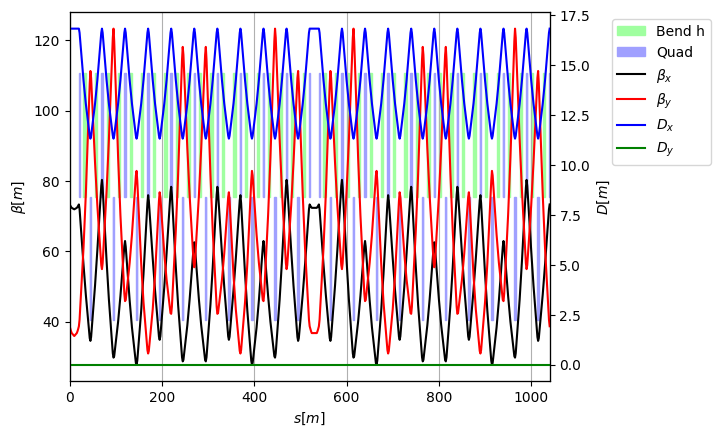

In [33]:
env['k1_ss.1'] = 0
env['k1_ss.2'] = 0
env['k1_ss.3'] = 0
tw = ring.twiss(method='4d')
tw.plot()

In [7]:
from ipywidgets import interact

In [8]:
fodo_init_cond['s'] = env['lss']

In [16]:
def match_twiss(k11 = 0.0, k12 = 0.0, k13 = 0.00, f_fodo = -30):
    #env['lss'] = 0
    # env['f_ss'] = 'lss / 2 '
    #env['k1_ss'] = k1
    env['f0'] = f_fodo
    env['k1_ss.1'] = k11
    env['k1_ss.2'] = k12
    env['k1_ss.3'] = k13
    tw = ring.twiss(method='4d')
    tw.plot(yl='betx bety')
    #plt.gca()[0].axhline(70, color='black')
    plt.axvline(env['lss'], color='black')
    plt.scatter(env['lss'], fodo_init_cond['betx'], color='black')
    plt.scatter(env['lss'], fodo_init_cond['bety'], color='red')
    #plt.xlim(0, 5 * env['lsection'])

    tw.plot(yl='alfx alfy')
    #plt.gca()[0].axhline(70, color='black')
    plt.axvline(env['lss'], color='black')
    plt.scatter(env['lss'], fodo_init_cond['alfx'], color='black')
    plt.scatter(env['lss'], fodo_init_cond['alfy'], color='red')
    #plt.xlim(0, 5 * env['lsection'])
    tw = tw.to_pandas()
    tw.index = tw['name']
    print(tw.loc['extrpt']['betx'])
interact(match_twiss, k11=(1e-4, 3e-2, 1e-4), k12=(1e-4, 3e-2, 1e-4), k13=(1e-4, 3e-2, 1e-4))


interactive(children=(FloatSlider(value=0.0001, description='k11', max=0.03, min=0.0001, step=0.0001), FloatSl…

<function __main__.match_twiss(k11=0.0, k12=0.0, k13=0.0, f_fodo=-30)>

Matching: model call n. 26               



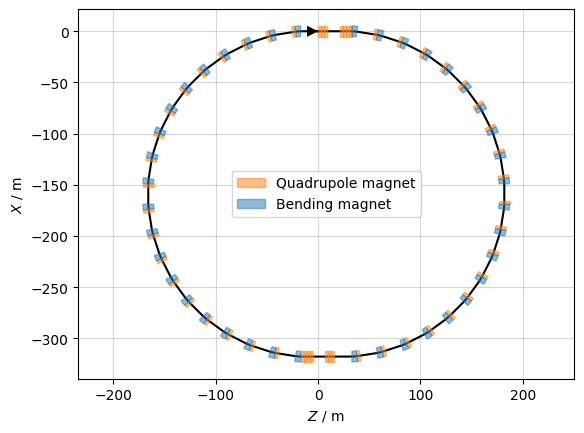

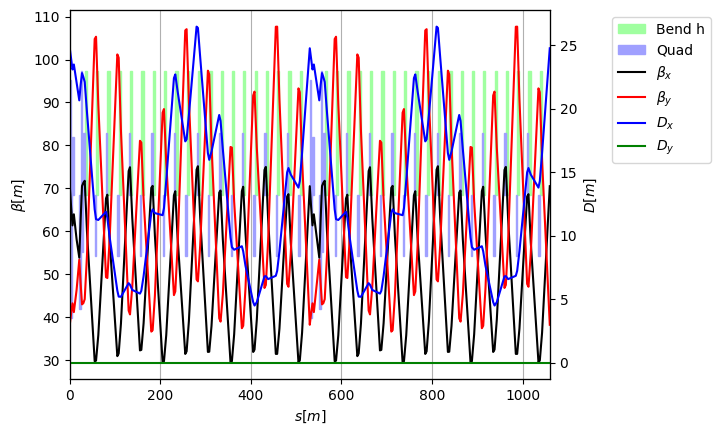

In [ ]:
env['lss'] = 30
env['f_ss'] = 'lss / 2 '
env['k1_ss'] = '1 / f_ss / lquad / 2'
env['k1_ss.1'] = 'k1_ss'
env['k1_ss.2'] = 'k1_ss'
env['k1_ss.3'] = 'k1_ss'


straight_section1 = env.new_line(name='ss1', components=[
    env.new('startss1', xt.Marker, at='0'),
    env.new('qs1.1', xt.Quadrupole, length='lquad', k1='k1_ss.1', at='lquad/2'),
    env.new('qs1.2', xt.Quadrupole, length='lquad', k1='-k1_ss.2', at='lquad + lquad/2'),
    env.new('qs1.3', xt.Quadrupole, length='lquad', k1='k1_ss.3', at='2*lquad + lquad/2'),

    # env.place(hbumper1, at='3*lquad + lbumper/2'),
    # env.place(hbumper2, at='lss/2 - bump_gap/2 - lbumper/2'),
    env.new('extrpt', xt.Marker, at='lss/2'),
    # env.place(hbumper3, at='lss/2 + bump_gap/2 + lbumper/2'),
    # env.place(hbumper4, at='lss - 3*lquad - lbumper/2'),

    env.new('qs1.4', xt.Quadrupole, length='lquad', k1='-k1_ss.1', at='lss - lquad*2 - lquad/2'),
    env.new('qs1.5', xt.Quadrupole, length='lquad', k1='k1_ss.2', at='lss - lquad - lquad/2'),
    env.new('qs1.6', xt.Quadrupole, length='lquad', k1='-k1_ss.3', at='lss - lquad/2'),
    
    env.new('endss1', xt.Marker, at='lss')
    ])

straight_section2 = env.new_line(name='ss2', components=[
    env.new('startss2', xt.Marker, at='0'),
    env.new('qs2.1', xt.Quadrupole, length='lquad', k1='k1_ss.1', at='lquad/2'),
    env.new('qs2.2', xt.Quadrupole, length='lquad', k1='-k1_ss.2', at='lquad + lquad/2'),
    env.new('qs2.3', xt.Quadrupole, length='lquad', k1='k1_ss.3', at='2*lquad + lquad/2'),

    env.new('qs2.4', xt.Quadrupole, length='lquad', k1='-k1_ss.1', at='lss - lquad*2 - lquad/2'),
    env.new('qs2.5', xt.Quadrupole, length='lquad', k1='k1_ss.2', at='lss - lquad - lquad/2'),
    env.new('qs2.6', xt.Quadrupole, length='lquad', k1='-k1_ss.3', at='lss - lquad/2'),
    env.new('endss2', xt.Marker, at='lss') 
    ])

components = [env.new('_start_point', xt.Marker)] + [straight_section1] + (number_of_FODO // 2)*[section] + [straight_section2] + (number_of_FODO // 2)*[section]

ring = env.new_line(components = components)

ring.particle_ref = xt.Particles(p0c=pc, mass0=xt.PROTON_MASS_EV) 
context = xo.ContextCpu()
ring.build_tracker(_context=context)

ring.survey().plot()


# opt = ring.match(solve=False, restore_if_fail=False,
#     vary=[
#         xt.VaryList(['k1_ss.1', 'k1_ss.2', 'k1_ss.3'], step=1e-7),
#     ],
#     targets=[
#         xt.TargetSet(at='endss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1),
#     ],
#     method='4d')
# opt.solve()

# opt = ring.match(solve=False, restore_if_fail=False,
#     vary=[
#         xt.VaryList(['k1_ss'], step=1e-7),
#     ],
#     targets=[
#         xt.TargetSet(at='endss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1e-3),
#     ],
#     method='4d')

opt = ring.match(solve=False, restore_if_fail=False,
    vary=[
        xt.VaryList(['k1_ss.1', 'k1_ss.2', 'k1_ss.3'], step=1e-7),
    ],
    targets=[
        xt.TargetSet(at='endss1', betx=fodo_init_cond['betx'], bety=fodo_init_cond['bety'], alfx=fodo_init_cond['alfx'], alfy=fodo_init_cond['alfy'], tol=1),
    ],
    method='4d')

opt.solve()

tw = ring.twiss(method='4d')
tw.plot()

tw = tw.to_pandas()
tw.index = tw['name']

#plt.ylim(-20, 10)
#plt.xlim(-env['lsection'], env['lsection'])

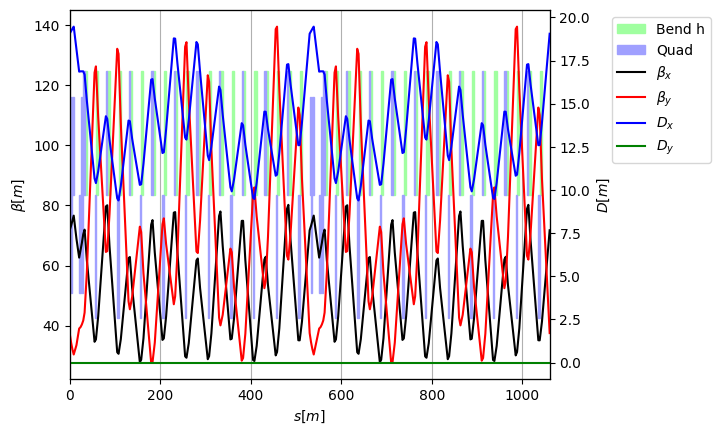

In [169]:
tw = ring.twiss(method='4d')
tw.plot()
#plt.xlim(0, 5*env['lss'])

<Axes: xlabel='s'>

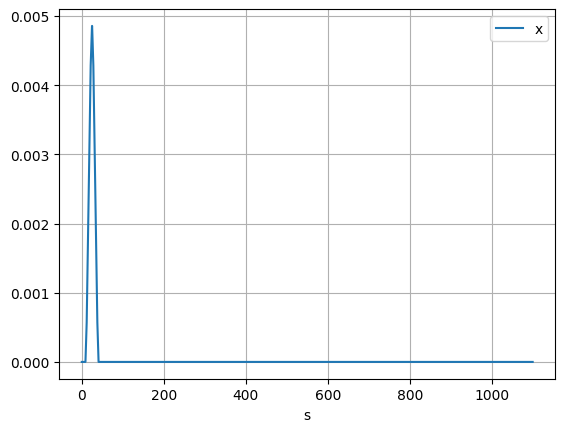

In [111]:
tw.plot(x='s', y='x', grid=True)    

ValueError: Invalid one-turn map: No coordinates respond to variations of y

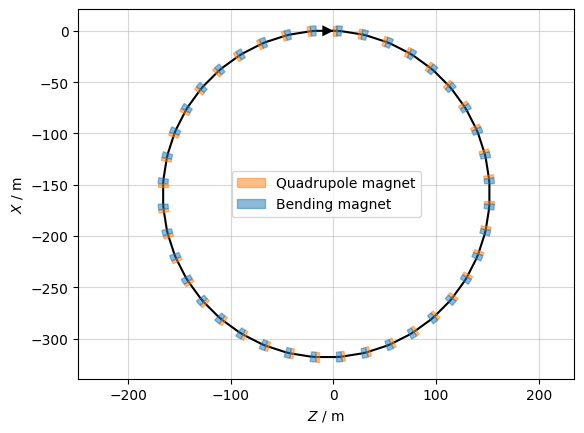

In [23]:
import xtrack as xt


lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
pc_GeV = 20.0
pc = pc_GeV*1e9

Brho = 3.3356*pc_GeV

lFODO = lcirc/number_of_FODO
theta_max = max_dipole_field * lbend / Brho
min_number_of_dipoles = round((2.0*np.pi)/theta_max)
number_of_dipoles_per_FODO = 2
number_of_dipoles = number_of_FODO * number_of_dipoles_per_FODO


target_bmax = 300.0

f_0 = 30

env = xt.Environment()
env['lquad'] = lquad
env['f0'] = f_0
env['k1'] = '1 / f0 / lquad'
env['lsection'] = lFODO
env['lbend'] = lbend
env['k0'] =  2 * np.pi / number_of_dipoles / lbend 
env['lsext'] = 0.5
env['k2f'] = 0
env['k2d'] = 0

bend = env.new('mb', xt.Bend, length='lbend', k0='k0', h='k0')
sextf = env.new('sextf', xt.Sextupole, length='lsext', k2='k2f')
sextd = env.new('sextd', xt.Sextupole, length='lsext', k2='k2d')

section = env.new_line(name='section', components=[
    env.new('start', xt.Marker, at='0'),
    env.new('q1', xt.Quadrupole, length='lquad', k1='k1', at='lquad/2'),
    env.place(bend, at='lquad + lbend/2'),
    env.new('q2', xt.Quadrupole, length='lquad', k1='-k1', at='lsection/2 + lquad/2'),
    env.place(bend, at='lsection/2 + lquad + lbend/2'),
    env.new('end', xt.Marker, at='lsection') 
])

env['bump_height'] = 2e-3
env['bump_gap'] = 0.5
env['lbumper'] = 3
env['ramp_length'] = 'lquad/2 + lbend/2 + lsection/4 - bump_gap/2 - lbumper/2 - lquad - lbend - lbumper/2'
env['k0_extr'] = 'bump_height / ramp_length / lbumper'
hbumper1 = env.new('hkick1', xt.Bend, k0='-k0_extr', h=0, length='lbumper')
hbumper2 = env.new('hkick2', xt.Bend, k0='k0_extr', h=0, length='lbumper')
hbumper3 = env.new('hkick3', xt.Bend, k0='k0_extr', h=0, length='lbumper')
hbumper4 = env.new('hkick4', xt.Bend, k0='-k0_extr', h=0, length='lbumper')

extr_section = env.new_line(name='section', components=[
    env.new('q1', xt.Quadrupole, length='lquad', k1='k1', at='lquad/2'),
    env.place(bend, at='lquad + lbend/2'),
    env.place(hbumper1, at='lquad + lbend + lbumper/2'),
    env.place(hbumper2, at='(lquad + lbend + lsection/2) / 2 - bump_gap/2 - lbumper/2'),
    env.place(hbumper3, at='(lquad + lbend + lsection/2) / 2 + bump_gap/2 + lbumper/2'),
    env.place(hbumper4, at='lsection/2 - lbumper/2'),
    env.new('q2', xt.Quadrupole, length='lquad', k1='-k1', at='lsection/2 + lquad/2'),
    env.place(bend, at='lsection/2 + lquad + lbend/2'),
    env.new('end', xt.Marker, at='lsection') 
    ])

env['lss'] = 40
env['f_ss'] = 'lss / 2'
env['k_ss'] = '0 * 1 / f_ss / lquad'

straight_section1 = env.new_line(name='section', components=[
    env.new('startss1', xt.Marker, at='0'),
    env.new('q1', xt.Quadrupole, length='lquad', k1='k_ss', at='lquad/2'),
    env.new('q2', xt.Quadrupole, length='lquad', k1='-k_ss', at='lquad + lquad/2'),
    env.new('q3', xt.Quadrupole, length='lquad', k1='k_ss', at='2*lquad + lquad/2'),

    env.place(hbumper1, at='3*lquad + lbumper/2'),
    env.place(hbumper2, at='lss/2 - bump_gap/2 - lbumper/2'),
    env.place(hbumper3, at='lss/2 + bump_gap/2 + lbumper/2'),
    env.place(hbumper4, at='lss - 3*lquad - lbumper/2'),

    env.new('q4', xt.Quadrupole, length='lquad', k1='k_ss', at='lss - lquad*2 - lquad/2'),
    env.new('q5', xt.Quadrupole, length='lquad', k1='-k_ss', at='lss - lquad - lquad/2'),
    env.new('q6', xt.Quadrupole, length='lquad', k1='k_ss', at='lss - lquad/2'),
    
    env.new('endss1', xt.Marker, at='lss') 
    ])

straight_section2 = env.new_line(name='section', components=[
    env.new('startss2', xt.Marker, at='0'),
    env.new('q1', xt.Quadrupole, length='lquad', k1='k_ss', at='lquad/2'),
    env.new('q2', xt.Quadrupole, length='lquad', k1='-k_ss', at='lquad + lquad/2'),
    env.new('q3', xt.Quadrupole, length='lquad', k1='k_ss', at='2*lquad + lquad/2'),

    env.new('q4', xt.Quadrupole, length='lquad', k1='k_ss', at='lss - lquad*2 - lquad/2'),
    env.new('q5', xt.Quadrupole, length='lquad', k1='-k_ss', at='lss - lquad - lquad/2'),
    env.new('q6', xt.Quadrupole, length='lquad', k1='k_ss', at='lss - lquad/2'),
    env.new('endss2', xt.Marker, at='lss') 
    ])

#components = [env.new('_start_point', xt.Marker)] + [straight_section1] + (number_of_FODO//2)*[section] + [straight_section2] + (number_of_FODO//2)*[section]

components = [env.new('_start_point', xt.Marker)] + (number_of_FODO)*[section] 

ring = env.new_line(components=components)

ring.particle_ref = xt.Particles(p0c=pc, mass0=xt.PROTON_MASS_EV) 
context = xo.ContextCpu()
ring.build_tracker(_context=context)

ring.survey().plot()

tw = ring.twiss(method='4d')
tw.plot()

# plt.ylim(-20, 10)
# plt.xlim(-env['lsection'], env['lsection'])

gamma = pc / xt.PROTON_MASS_EV
sigma_max = lambda emitt_norm, beta: np.sqrt(emitt_norm*beta / gamma)
tw['10sy_mm'] = sigma_max(emitt_norm=2e-6, beta=tw['bety']) * 1e3 * 10
tw['10sx_mm'] = sigma_max(emitt_norm=2e-6, beta=tw['betx']) * 1e3 * 10
tw.to_pandas().plot(x='s', y=['10sx_mm', '10sy_mm'])
plt.axhline(31.4, color='black')
plt.grid(True)


env['bump_height'] = 2e-3 
tw = ring.twiss(method='4d').to_pandas()
tw.index = tw['name']

fig, ax = plt.subplots()
for idx, row in tw.filter(like='hkick', axis=0).iterrows():
    ax.axvline(row['s'], color='red', linestyle='--')
for idx, row in tw.filter(like='q', axis=0).iterrows():
    ax.axvline(row['s'], color='green', linestyle='--')
tw.plot(x='s', y='x', grid=True, xlim=(0, env['lsection']), ax=ax)
tw.plot(x='s', y='y', grid=True, xlim=(0, env['lsection']), ax=ax)

In [21]:
number_of_FODO //2

10

In [114]:
dqx_target, dqy_target = 0, 0

n_part = 1000
N_EX, N_EY = 2e-6, 2e-6
DPP = 1e-5

x_norm, px_norm = xp.generate_2D_gaussian(num_particles=n_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_particles=n_part)

zeta = 0.0
dpp = np.random.rand(n_part) * DPP

# particles = ring.build_particles(
#     method="4d",
#     zeta=zeta,
#     delta=dpp,
#     x_norm=x_norm,
#     px_norm=px_norm,
#     y_norm=y_norm,
#     py_norm=py_norm,
#     nemitt_x=N_EX,
#     nemitt_y=N_EY,
# )

opt = ring.match(solve=False,
    vary=[
        xt.VaryList(['k2f', 'k2d'], step=1e-7),
    ],
    targets=[
        xt.TargetSet(dqx=dqx_target, dqy=dqy_target, tol=1e-3),
    ],
    method='4d')
opt.solve()

ClosedOrbitSearchError: Particle lost, p.state = -1

In [49]:
opt.log()

Table: 7 rows, 14 cols
iteration                   penalty alpha tag tol_met target_active hit_limits vary_active ...
0                           3.44536    -1     nn      yy            nn         yy         
1                          0.841852     0     ny      yy            nn         yy         
2                          0.106129     0     ny      yy            nn         yy         
3                         0.0341858     0     ny      yy            nn         yy         
4                        0.00585881     0     ny      yy            nn         yy         
5                        0.00113853     0     ny      yy            nn         yy         
6                       0.000331837     0     yy      yy            nn         yy         

In [50]:
env['k2f'], env['k2d']

(0.022271196494580238, -0.024208956339396764)

# Tracking

In [11]:
num_particles = 1000
sx = 1e-3 
sy = 1e-3 
spx = 1e-3 / gamma
spy = 1e-3 / gamma
# particles = ring.build_particles(
#                         x =  np.random.normal(0, sx, num_particles) ,
#                         px = np.random.normal(0, spx, num_particles),
#                         y =  np.random.normal(0, sy, num_particles),
#                         py = np.random.normal(0, spy, num_particles),
#                         zeta = np.zeros(num_particles),
#                         delta = np.zeros(num_particles)
# )

particles = ring.build_particles(
                        x_norm = np.random.normal(0, 1, num_particles),
                        px_norm = np.random.normal(0, 1, num_particles),
                        y_norm = np.random.normal(0, 1, num_particles),
                        py_norm = np.random.normal(0, 1, num_particles),
                        zeta = np.zeros(num_particles),
                        delta = np.zeros(num_particles),
                        nemitt_x=2e-6,
                        nemitt_y=2e-6,
                        method='4d'
)

# particles = ring.build_particles(
#                         x_norm = 0,
#                         px_norm = 0,
#                         y_norm = 0,
#                         py_norm = 0,
#                         # zeta = 0,
#                         # delta = 0,
#                         nemitt_x = 0,
#                         nemitt_y = 0,
#                         method='4d'
# )
# Reference mass, charge, energy are taken from the reference particle.
# Particles are allocated on the context chosen for the line.

## Track (saving turn-by-turn data)
n_turns = 100
ring.track(particles, num_turns=n_turns, freeze_longitudinal=True,
              turn_by_turn_monitor=True)

In [12]:
beam = ring.record_last_track

In [13]:
gam, beta, alpha = tw.to_pandas().loc[0][['gamx', 'betx', 'alfx']]

cs_inv = lambda x, px: gam * x**2 + 2 * alpha * x * px + beta * px**2

emittance =  4.663611243889776 um


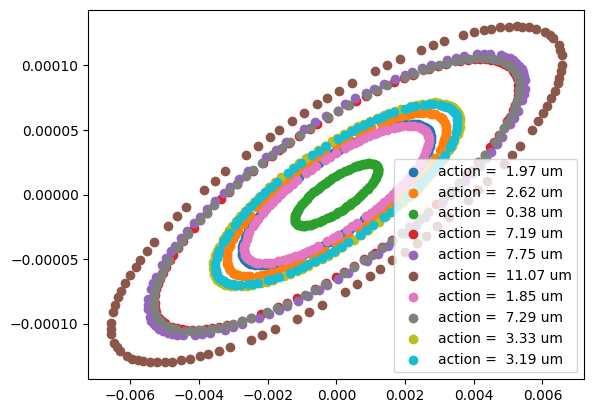

In [14]:
actions = []
for particle_id in range(10):
    x = beam.x[:, 0][beam.particle_id[:, 0] == particle_id]
    px = beam.px[:, 0][beam.particle_id[:, 0] == particle_id]
    action = cs_inv(x, px)[0]
    actions.append(action)
    plt.scatter(beam.x[beam.particle_id == particle_id], beam.px[beam.particle_id == particle_id], label=f'action = {action * gamma * 1e6 : .2f} um');
plt.legend()

print('emittance = ', np.mean(actions) * gamma * 1e6, 'um')